In [1]:
#library imports
import numpy as np #numpy is a math library 
import pandas as pd #pandas is a data library for manipulating information, my main library
import matplotlib as mpl #equivalent to R for plotting
import matplotlib.pyplot as plt
import seaborn as sns # a wrapper for matplot lib that makes automatically pretty graphs
from funcsLibPrep import * # this is a custom set of functions, primarily for dealing with applied biosystems data
from scipy import stats # for linear regression later
## stats.gmean for exponential data!!

In [2]:
#display magic for seaborn and mpl
%matplotlib inline
sns.set(context="talk") #set seaborn graphs to be pretty
# additional wrapper functions for AB systems

In [3]:
def process(fn, data = None):
    sampleSetup = pd.read_excel(fn, 'Sample Setup', skiprows=7)
    df = importAmplification(fn).merge(sampleSetup)
    results = pd.read_excel(fn, skiprows=range(
        0, 7), sheet_name='Results').dropna(thresh=5).dropna(
            axis=1,
            thresh=5).drop(columns=['Task', 'Reporter',
                          'Quencher'])  #import results sheet, drop null rows, drop null columns, drop stupid columns
    results['Ct_clean'] = pd.to_numeric(results['Cт'], errors='coerce') #this is a cleaning line for later
    
    title = fn.rstrip('.xls')
    return df, results, title

# in situ PCR pilot studies (v4)

## Generally

* gauging efficiency of known number of nuclei and in situ PCR against a panel of reference genes
* reference genes with order-of-magnitude copy differences ==> "standard curve" 
    
| Gene      | Copies/genome |
| ----------- | ----------- |
| Col1A      | 2       |
| MTV   | 10        |
| 18S | 100 |
| L1 | 2500 |

## standard curves in qPCR

* a 100% efficient PCR reaction doubles in DNA quantity every cycle
* ~3 cycle difference =  1 order of magnitude difference in DNA amount

# v4 controls, curves by sample

In [4]:
fn = '200812_Kl-insituPCR-geneStdCurve-v4.xls'
df, results, title = process(fn) #import data

controlNames = ['NTC', '.05 ng (low)', '.5 ng (high)']
tip_order = ['P10', 'P20', 'P300', 'P1000']

df['SampleName'] = pd.Categorical(df['Sample Name'], controlNames + tip_order, ordered = True)

results['SampleName'] = pd.Categorical(results['Sample Name'], controlNames + tip_order, ordered = True)

controlData = df[df['Sample Name'].isin(controlNames)]
controlResults = results[results['Sample Name'].isin(controlNames)]

In [5]:
g = sns.relplot(x='Cycle',
                y='Rn',
                hue="Target Name",
                col="Sample Name",
                col_wrap = 3,
                data=controlData,
                palette='Dark2',
                kind="line")
g.fig.suptitle("v4 controls, by sample", x=0.4,
               y=1);  # titling graphs is helpful;
plt.close()

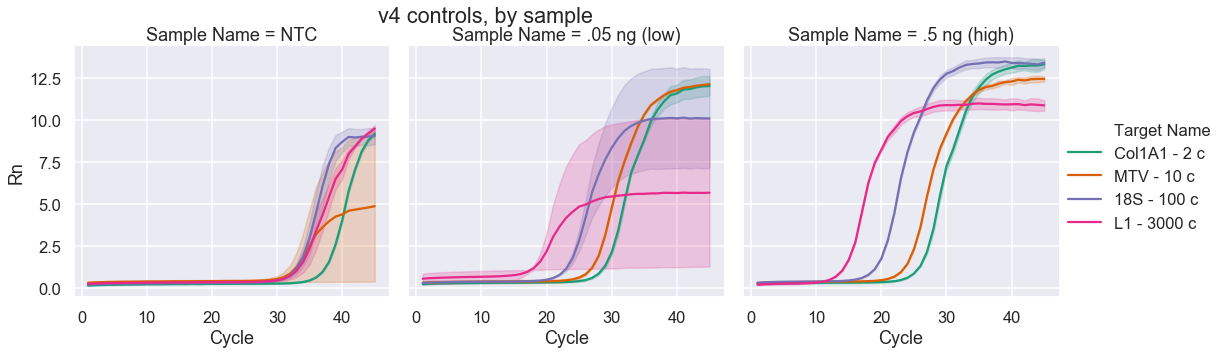

In [6]:
g.fig

* The .05 ng L1 discrepancy (compared to .5) is due to one of the replicates failing entirely -- I think it's likely I didn't add template. The successful curve follows the top line, and would be similar in shape to L1 x.5 ng.

# v4 controls, curves by target

In [7]:
g = sns.relplot(x='Cycle',
                y='Rn',
                hue="Sample Name",
                col="Target Name",
                col_wrap=2,
                data=controlData,
                palette='Dark2',
                kind="line")
g.fig.suptitle("v4, control curves by Target", x = .5, y = 1.03)  
plt.close()

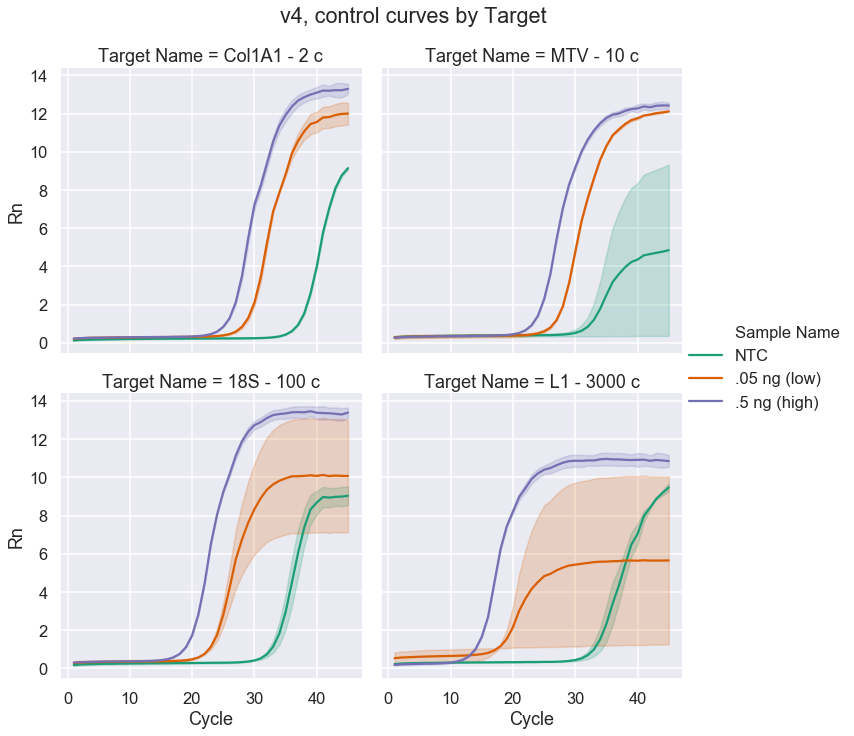

In [8]:
g.fig

* same L1 discrepancy as previously, otherwise things look about normal.
* average cQ difference in subslide 

In [9]:
grp = controlResults.groupby(['Target Name', 'SampleName'])['Ct_clean'].agg(['mean', stats.gstd]).dropna().sort_values(['Target Name', 'SampleName'])
grp['diff_mean_Ct'] = grp['mean'].transform(lambda mean: mean.diff(periods = -1)) #show diffs between ct means. for triplicate, geom mean would be appropriate and matter, but doesn't play nicely with null values
grp.round(2) # difference of 3-4 cycles between template order of magnitude dilutions

mean  gstd  diff_mean_Ct
Target Name  SampleName                             
18S - 100 c  NTC           33.41  1.03          9.92
             .05 ng (low)  23.49  1.03          3.99
             .5 ng (high)  19.51  1.00        -18.42
Col1A1 - 2 c NTC           37.93  1.00          8.50
             .05 ng (low)  29.43  1.01          3.00
             .5 ng (high)  26.43  1.01         -7.77
L1 - 3000 c  NTC           34.20  1.04         19.35
             .5 ng (high)  14.85  1.00        -12.23
MTV - 10 c   .05 ng (low)  27.08  1.00          3.36
             .5 ng (high)  23.72  1.00           NaN

In [10]:
# dropping l1 from analysis entirely as it's broadly out of range of interest
limDF = df.query("~`Target Name`.str.contains('L1')").copy()
limResults = results.query("~`Target Name`.str.contains('L1')").copy()
sampleDF = limDF[limDF['SampleName'].isin(tip_order)]
sampleResults = limResults[limResults['Sample Name'].isin(controlNames)]

In [11]:
g = sns.relplot(x='Cycle',
                y='Rn',
                hue="Sample Name",
                col="Target Name",
                col_wrap = 2,
                data=sampleDF,
                palette='Dark2',
                kind="line", ci = None)
g.fig.suptitle("v4, punch curves by target, sans L1",  x=0.4, y=1.03)
plt.close()

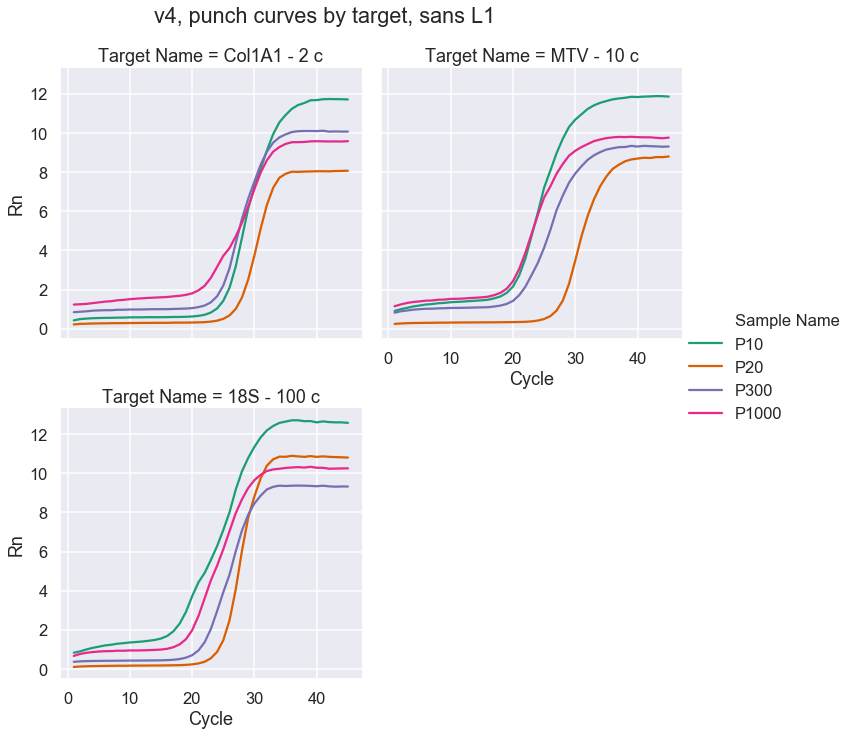

In [12]:
# L1 dropped from analysis as it's broadly out of range of interest
g.fig

18S and MTV approximate curves with visible differences. Col1A1 seems generally to be...inefficient at all concentrations -- Ct values cluster at the high end of acceptable. See next slide for distribution.

## Ct values

In [13]:
g = sns.catplot(x="Sample Name",
                y="Ct_clean",
                hue="Target Name",
                data=limResults,
                kind="swarm")

g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle("Swarmplot of Ct values spread by template type", y=1.03)
plt.close()

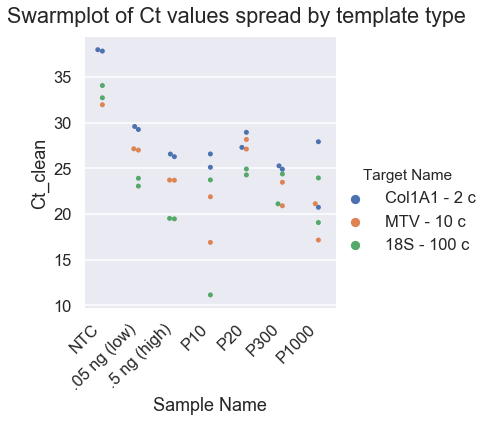

In [14]:
g.fig

# Ct values

In [15]:
g = sns.catplot(x="Target Name",
                     y="Ct_clean",
                     hue="Sample Name",
                     data=limResults, kind = "swarm")

g.set_xticklabels(rotation=45, ha = 'right')
g.fig.suptitle("Swarmplot of Ct value spread by target", y = 1.03)
plt.close()

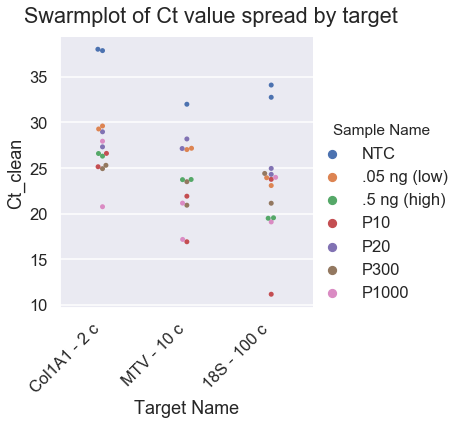

In [16]:
g.fig

In [17]:
 ## looking at actual values + diffs
grp = results.groupby(['Target Name', 'SampleName'])['Ct_clean'].agg([stats.gmean, stats.gstd]) #make group
grp['diff_mean_Ct'] = grp['gmean'].transform(lambda mean: mean.diff(+1)) #show diffs between ct means. geom mean used for general analysis reasons, but doesn't make a difference to the actual value when there are only two values
grp = grp.round(2)
grp

gmean  gstd  diff_mean_Ct
Target Name  SampleName                             
18S - 100 c  NTC           33.40  1.03           NaN
             .05 ng (low)  23.49  1.03         -9.91
             .5 ng (high)  19.51  1.00         -3.98
             P10           16.27  1.71         -3.23
             P20           24.61  1.02          8.34
             P300          22.70  1.11         -1.91
             P1000         21.38  1.17         -1.32
Col1A1 - 2 c NTC           37.93  1.00         16.55
             .05 ng (low)  29.43  1.01         -8.50
             .5 ng (high)  26.43  1.01         -3.00
             P10           25.85  1.04         -0.59
             P20           28.12  1.04          2.27
             P300          25.10  1.01         -3.02
             P1000         24.07  1.23         -1.03
L1 - 3000 c  NTC           34.19  1.04         10.12
             .05 ng (low)    NaN   NaN           NaN
             .5 ng (high)  14.85  1.00           NaN
             P10           14.94  1.05          0.09
             P20             NaN   NaN           NaN
             P300          12.72  1.10           NaN
             P1000         15.86  1.44          3.14
MTV - 10 c   NTC             NaN   NaN           NaN
             .05 ng (low)  27.08  1.00           NaN
             .5 ng (high)  23.72  1.00         -3.36
             P10           19.24  1.20         -4.48
             P20           27.64  1.03          8.40
             P300          22.16  1.09         -5.48
             P1000         19.05  1.16         -3.12

# Nuclei and nanograms
* reference template is extracted genomic DNA of a knowable ng/ul
* the # of nuclei in each is approximately:
  * n ng DNA * (1000 pg/1 ng) * (1 nuclei/6pg) = # nuclei

In [18]:
# wrapper functions for nuclei <-> ng conversions
def ng_to_nuclei(ng):
    return ng * 1000 / 6
def nuclei_to_ng(nuclei):
    return  nuclei * 6 /1000

## punch sizes and nuclei

In [19]:
#measurements with standard ruler, waiting on caliper batteries
tipDict = {
    "P1000": 1.1,
    "P300": 1,
    "P20": .75,
    "P10": .6
}  

# visual inspection of images, likely order of magnitude correct
area_umSq = 10000 #measured with Fiji
nuclei = 25 #hand counted, not accounting for z stacking
density = nuclei / area_umSq #math

In [20]:
punch = pd.DataFrame.from_dict(tipDict, orient="index",
                               columns=['diam_mm']).reset_index().rename(
                                   {"index": "template"},
                                   axis=1)  #convert to dataframe + clean up
punch['area_mm_sq'] = punch['diam_mm'].apply(
    lambda diam: np.pi * np.square(diam / 2))
punch['area_uM_sq'] = punch['area_mm_sq'] * np.square(
    1000)  #important to do *squared* dimensional analysis
punch['total_nuclei'] = punch['area_uM_sq'] * density
punch['ng'] = punch.total_nuclei.apply(nuclei_to_ng)
templates = {'.5 ng (high)': .5, '.05 ng (low)': .05, 'NTC': 0}
temp = pd.DataFrame.from_dict(templates, orient="index",
                              columns=['ng']).reset_index().rename(
                                  {"index": "template"}, axis=1)
temp['total_nuclei'] = temp.ng.apply(ng_to_nuclei)
templates = punch.append(temp, sort = False)

## calculated approximations

In [21]:
templates.round(2) # ball park estimates for comparing to later data

,template,diam_mm,area_mm_sq,area_uM_sq,total_nuclei,ng
0,P1000,1.10,0.95,950331.78,2375.83,14.25
1,P300,1.00,0.79,785398.16,1963.50,11.78
2,P20,0.75,0.44,441786.47,1104.47,6.63
3,P10,0.60,0.28,282743.34,706.86,4.24
0,.5 ng (high),NaN,NaN,NaN,83.33,0.50
1,.05 ng (low),NaN,NaN,NaN,8.33,0.05
2,NTC,NaN,NaN,NaN,0.00,0.00


# v4, standard curves of gel punches x primers, for amplicons represented in the genome at ~standard curve amounts

In [22]:
# amp, results, title = process(fn)

## standards look like standards

In [23]:
ax = sns.lineplot(x='Cycle',
            y='Rn',
            hue="Target Name",
                  style = "Sample Name",
            data=limDF.query('`Sample Name`.str.contains("5")'),
            palette='Dark2', ci = None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title = "Amplification, gDNA template")
plt.close() #plotting high vs low to investigate shapes

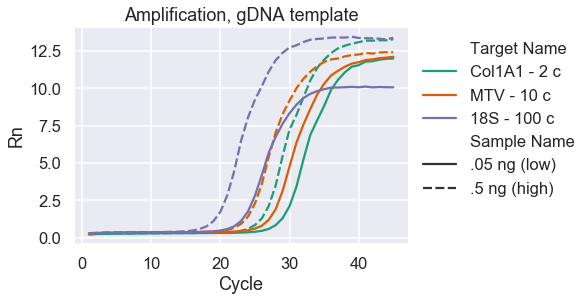

In [24]:
ax.get_figure()

# DIY standard curve

In [25]:
#dict for approximate values
genome_copies = {
    "col1a1": 2,
    "mtv": 10,
    "18s": 100,
    "L1": 3000,
    "L1half": 1500
}

mapping = {
    "Col1A1 - 2 c": "col1a1",
    "MTV - 10 c":"mtv",
    "18S - 100 c": '18s',
    "L1 - 3000 c": 'L1'}


In [26]:
calc = templates.add_suffix("_calc")
limResults['TargetName'] = limResults['Target Name'].map(mapping,
                                                         na_action="ignore")

limResults['genomeCopies'] = limResults['TargetName'].map(genome_copies,
                                                          na_action="ignore")

d = limResults.merge(calc,
                     left_on="Sample Name",
                     right_on="template_calc",
                     how="outer")

d['num_amplicons_calc'] = d['total_nuclei_calc'] * d['genomeCopies']

In [27]:
d['log2_num_amplicons_calc'] = np.log2(d['num_amplicons_calc'].replace(0, np.nan))

## Linear regression to standards

In [36]:
stds = d[d['Sample Name'].isin(controlNames[1:])]

x = 'log2_num_amplicons_calc'
y = 'Ct_clean'

m, b, r_value, p_value, std_err = stats.linregress(stds[x], stds[y])
ct_line = m*d[x] + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

# considering range, not really interested in working  too far outside our range
is_ranged = d['Ct_clean'].between(stds[y].min(), stds[y].max())
ranged = d[is_ranged].copy()
ranged['log2_num_amplicons_curveExp'] = (ranged[y] - b) / m
ranged['num_amplicons_curveExp'] = np.exp2(ranged[x])
samples = ranged[ranged['SampleName'].isin(tip_order)]

In [37]:
ax = sns.scatterplot('log2_num_amplicons_curveExp',
                     y,
                     data=samples,
                     hue="Sample Name",
                     s=60)
ax = sns.lineplot(x,
                  ct_line,
                  label='Linear regression to standards, {}'.format(line_eq),
                  data=stds, ax=ax)

ax = sns.scatterplot(x,
                     y,
                     marker='o',
                     label='Standards',
                     color="r",
                     s=75,
                     alpha=1,
                     data=stds,
                     ax=ax)



# ax = sns.pointplot('log2_num_amplicons_curvecalc',
#                    'Ct_clean',
#                    data=ranged,
#                    join=False,
#                    hue='SampleName', dodge = .5, markers = "x", ax= ax)
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(title="Linear regression on ct values and log amplicon counts")
plt.close()

R = -0.9948199560169659


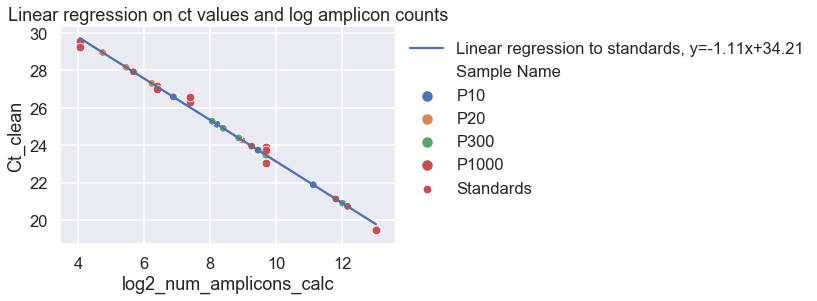

In [38]:
#again figure aesthestics are annoying but ok! fine
print("R = {}".format(r_value))# ax

ax.get_figure()

# correlation between calculated + 'empirical'

In [39]:
# correlation between calculated and empirical
x= 'log2_num_amplicons_calc'
y= 'log2_num_amplicons_curveExp'
m, b, r_value, p_value, std_err = stats.linregress(samples[x], samples[y])
ct_line = m*ranged[x] + b
line_eq = "y={:.2f}x+{:.2f}".format(m, b)

In [40]:
ax = sns.lineplot(x,
                  ct_line,
                  label='Ct regression line, {}'.format(line_eq),
                  data=ranged)
ax = sns.scatterplot(x, y, label="Data", data=samples, hue="Target Name", style = "SampleName", ax=ax)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set_title("Log2 amplicon counts, calculated vs empirical", y = 1.05)

ax.axis(xmin = ranged[x].min()-1, xmax = ranged[x].max()+1, ymin=ranged[x].min()-1,ymax=ranged[x].max()+1)
ax.set_aspect('equal', adjustable='box')
sns.despine(ax=ax,
            top=True,
            right=True,
            left=False,
            bottom=False,
            offset=None,
            trim=False)

plt.close()


R = 0.5263991630033599


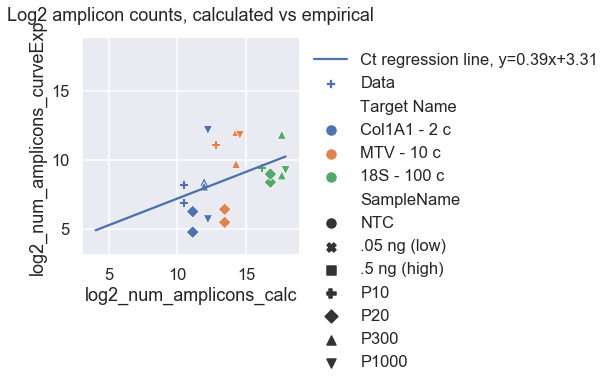

In [41]:
print("R = {}".format(ranged[x].corr(ranged[y])))# ax
ax.get_figure()

## distribution across sizes

In [34]:
g = sns.catplot(x,
                y,
                hue="Target Name",
                col="SampleName",
                col_wrap=3,
                data=ranged,
                palette='Dark2',
                kind="swarm",
                sharex=True,
                sharey=True)

g.fig.suptitle("Expected vs actual amplification values",  x=0.5, y=1)

# fmt = lambda x: "{:.2f}%".format(x)


for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    for i,l in enumerate(labels):
        if(i%2 == 0): labels[i] = '' # skip even labels
    ax.set_xticklabels(labels, rotation=40)
    
plt.close()

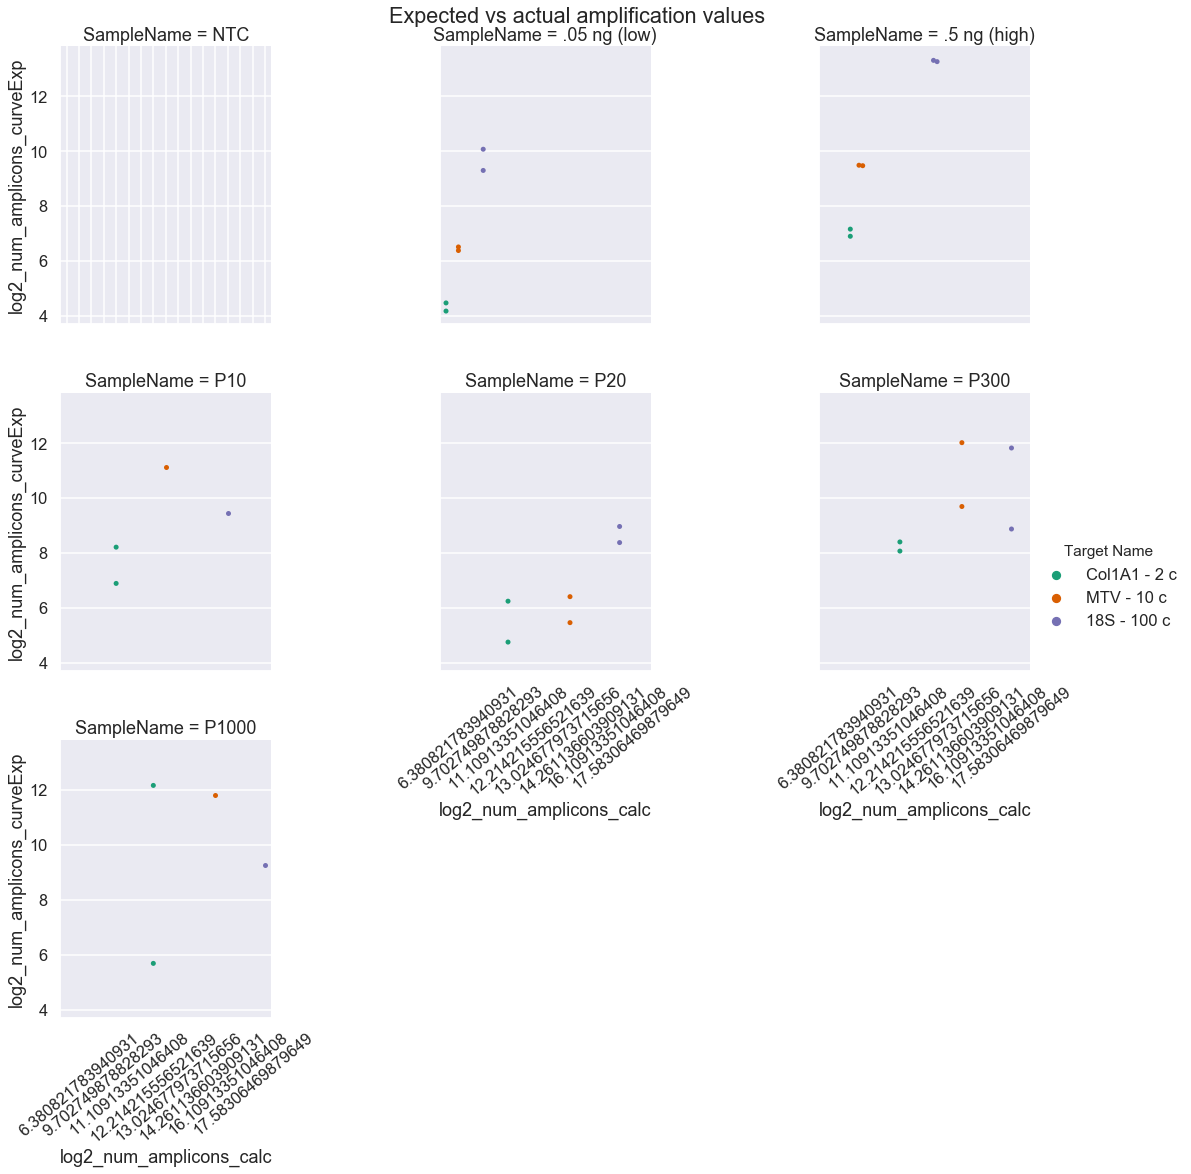

In [35]:
# not happy with these figure ticks at all but ok for now
g.fig